# 8. Кейс-стади

In [1]:
import pandas as pd
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import re
import nltk
from nltk.corpus import stopwords
from gensim import corpora
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

### Задание 1
Вернемся к набору данных о видеоиграх.

Ответьте на следующие вопросы:

1) Как критики относятся к спортивным играм?

2) Критикам нравятся больше игры на PC или на PS4?

3) Критикам больше нравятся стрелялки или стратегии?

Для каждого вопроса:

- сформулируйте нулевую и альтернативную гипотезы;
- выберите пороговый уровень статистической значимости;
- опишите полученные результаты статистического теста.

In [ ]:
games = pd.read_csv('https://raw.githubusercontent.com/obulygin/pyda_homeworks/master/stat_case_study/vgsales.csv')
games

1) Как критики относятся к спортивным играм?

- H0: средняя удовлетворенность критиков играми в жанре Sports >= 70 баллов
- H1: средняя удовлетворенность критиков играми в жанре Sports < 70 баллов

Пусть alpha = 0.05

In [ ]:
sport = games[['Name', 'Genre', 'Global_Sales', 'Critic_Score']]
sport = sport[sport['Genre'] == 'Sports']

sport.describe()

,Global_Sales,Critic_Score
count,2348.000000,1194.000000
mean,0.567291,71.968174
std,2.084460,13.878433
min,0.010000,19.000000
25%,0.090000,64.000000
50%,0.220000,75.000000
75%,0.552500,82.000000
max,82.530000,98.000000


In [ ]:
sport[sport['Critic_Score'].isnull()]

In [ ]:
#предполагаю, что пропуски можно заполнить на основании данных столбца "глобальные продажи"

# sport['Critic_Score'] = sport['Critic_Score'].fillna(sport.groupby('Global_Sales')['Critic_Score'].transform('median'))

# sport.describe()

**Давайте посмотрим на гистограмму**

In [ ]:
plt.hist(sport['Critic_Score'])

In [ ]:
alpha = 0.05
result = st.ttest_1samp(sport['Critic_Score'], 70, alternative='less')

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, среднее меньше 70 баллов')
else:
    print('Не отвергаем нулевую гипотезу')

Не отвергаем нулевую гипотезу


- опишите полученные результаты статистического теста:

Критики (при том, что в данных около 50% игр не имеют оценки) достаточно высоко оценивают игры в жанре Sport, средняя оценка превышает 70 баллов из 100 возможных.

2) Критикам нравятся больше игры на PC или на PS4?

- H0: удовлетворенность критиков играми на PC & PS4 одинаковая
- H1: удовлетворенность критиков играми на PC & PS4 разная (больше или меньше, там посмотрим)

Пусть alpha = 0.05

In [ ]:
platform = games[['Name', 'Platform', 'Global_Sales', 'Critic_Score']]
platform = platform[(platform['Platform'] == 'PC') | (platform['Platform'] == 'PS4')]

platform.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1367 entries, 31 to 16709
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          1367 non-null   object 
 1   Platform      1367 non-null   object 
 2   Global_Sales  1367 non-null   float64
 3   Critic_Score  967 non-null    float64
dtypes: float64(2), object(2)
memory usage: 53.4+ KB


In [ ]:
#platform.describe()

In [ ]:
#plt.hist(platform['Critic_Score'])

In [ ]:
# platform['Critic_Score'] = platform['Critic_Score'].fillna(platform.groupby('Global_Sales')['Critic_Score'].transform('median'))
# platform.describe()

In [ ]:
plt.hist(platform['Critic_Score'])

In [ ]:
pl_PC = platform[platform['Platform'] == 'PC']
pl_PS4 = platform[platform['Platform'] == 'PS4']

In [ ]:
alpha = 0.05
result = st.ttest_ind(pl_PC['Critic_Score'], pl_PS4['Critic_Score'], equal_var=False)

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, удовлетворенность критиков играми на PC & PS4 разная')
else:
    print('Не отвергаем нулевую гипотезу')

Не отвергаем нулевую гипотезу


Вывод: так как мы не отвергаем H0, то можем сказать, что игроки в целом одинаково удовлетворены играми на PC и играми на PS4.
Войну между пэкашниками и консольщиками можно считать завершённой :) 

<small>Хотя в шутеры с геймпада рубиться - это для извращенцев))))) такое вот имхо</small>

3) Критикам больше нравятся стрелялки или стратегии?

- H0: критики одинаково оценивают стрелялки и стратегии
- H1: критики по-разному оценивают стрелялки и стратегии

Пусть alpha = 0.05

In [ ]:
games['Genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

In [ ]:
huinya = games[['Name', 'Genre', 'Global_Sales', 'Critic_Score']]
shoot = huinya[huinya['Genre'] == 'Shooter']
strat = huinya[huinya['Genre'] == 'Strategy']

shoot.info(), strat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1323 entries, 9 to 16710
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          1323 non-null   object 
 1   Genre         1323 non-null   object 
 2   Global_Sales  1323 non-null   float64
 3   Critic_Score  944 non-null    float64
dtypes: float64(2), object(2)
memory usage: 51.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 683 entries, 168 to 16706
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          683 non-null    object 
 1   Genre         683 non-null    object 
 2   Global_Sales  683 non-null    float64
 3   Critic_Score  302 non-null    float64
dtypes: float64(2), object(2)
memory usage: 26.7+ KB


(None, None)

In [ ]:
# shoot['Critic_Score'] = shoot['Critic_Score'].fillna(shoot.groupby('Global_Sales')['Critic_Score'].transform('median'))
# strat['Critic_Score'] = strat['Critic_Score'].fillna(strat.groupby('Global_Sales')['Critic_Score'].transform('median'))

In [ ]:
alpha = 0.05
result = st.ttest_ind(shoot['Critic_Score'], strat['Critic_Score'], equal_var=False)

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу, критики по-разному оценивают стрелялки и стратегии')
else:
    print('Не отвергаем нулевую гипотезу')

Не отвергаем нулевую гипотезу


результат странный, надо посмотреть визуально на распределение оценок

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


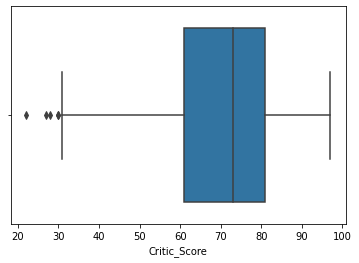

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


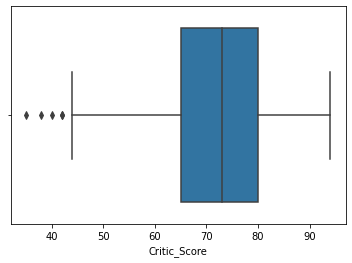

In [ ]:
sns.boxplot(shoot['Critic_Score'])
plt.show()
sns.boxplot(strat['Critic_Score'])

хм, действительно оценки критиков шутеров и стратегий не сильно различаются, окей

### Задание 2
Реализуйте базовую модель логистической регрессии для классификации текстовых сообщений (используемые данные здесь) по признаку спама. Для этого:

- Привидите весь текст к нижнему регистру;
- Удалите мусорные символы;
- Удалите стоп-слова;
- Привидите все слова к начальной форме;
- Преобразуйте все сообщения в вектора TF-IDF. Можете поэкспериментировать с параметрами TfidfVectorizer;
- Разделите данные на тестовые и тренировочные в соотношении 30/70, укажите random_state=42. Используйте train_test_split;
- Постройте модель логистической регрессии, укажите random_state=42, оцените ее точность на тестовых данных;
- Опишите результаты при помощи confusion_matrix;
- Постройте датафрейм, который будет содержать все исходные тексты сообщений, классифицированные неправильно (с указанием фактического и предсказанного).

In [30]:
spam = pd.read_csv('https://raw.githubusercontent.com/obulygin/pyda_homeworks/master/stat_case_study/spam.csv')
spam.loc[spam.Category == 'ham', 'Class'] = 1
spam.loc[spam.Category == 'spam', 'Class'] = 0

spam['Class'] = spam['Class'].astype('int')
spam = spam.drop(['Category'], axis=1)

In [31]:
spam_class = spam['Class']

In [32]:
#Привидите весь текст к нижнему регистру
spam['Message'] = spam['Message'].str.lower()

#Удалите мусорные символы
spam['Message'] = spam['Message'].replace(['[\W_]+'], [' '], regex=True)

In [ ]:
#Удалите стоп-слова:
spam['Message'] = spam['Message'].str[1:-1].str.split(' ').tolist()

nltk.download('stopwords')
stopwords_set = set(stopwords.words('english'))
spam['Message'] = pd.Series([[word for word in text if word not in stopwords_set] for text in spam['Message']])

In [ ]:
#Привидите все слова к начальной форме:
nltk.download('omw-1.4')
nltk.download('wordnet')
wordnet_lemmatizer = WordNetLemmatizer()

spam['Message'] = pd.Series([wordnet_lemmatizer.lemmatize(word) for word in text] for text in spam['Message'])

# spam['Message']

In [36]:
#Превращаем это дерьмо в строку, иначе fit_transform заругается
spam['Message'] = spam['Message'].apply(lambda x: ' '.join(x))

In [37]:
#Преобразуйте все сообщения в вектора TF-IDF:

tfidf = TfidfVectorizer(stop_words=list(stopwords_set))
tfidf_matrix = tfidf.fit_transform(spam['Message'])
names = tfidf.get_feature_names_out()
tfidf_matrix = pd.DataFrame(tfidf_matrix.toarray(), columns=names)

In [38]:
tfidf_matrix

,00,000,000pes,007,008704050406,0089,0121,01223585236,01223585334,0125698789,...,zero,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,ú1,〨ud
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5568,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
tfidf_matrix.describe()

,00,000,000pes,007,008704050406,0089,0121,01223585236,01223585334,0125698789,...,zero,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,ú1,〨ud
count,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,...,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000,5572.000000
mean,0.000622,0.001292,0.000044,0.000082,0.000100,0.000047,0.000060,0.000060,0.000084,0.000102,...,0.000073,0.000056,0.000058,0.000058,0.000075,0.000056,0.000051,0.000029,0.000042,0.000063
std,0.012670,0.019421,0.003249,0.004353,0.005282,0.003533,0.004494,0.004481,0.004427,0.007580,...,0.005484,0.004164,0.004359,0.004340,0.005571,0.004208,0.003788,0.002180,0.003131,0.004699
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.387454,0.679902,0.242555,0.230066,0.288804,0.263717,0.335423,0.334502,0.233708,0.565823,...,0.409377,0.310791,0.325416,0.323964,0.415844,0.314143,0.282794,0.162708,0.233741,0.350773


In [40]:
#Разделите данные на тестовые и тренировочные в соотношении 30/70, укажите random_state=42

x_train, x_test, y_train, y_test = train_test_split(tfidf_matrix, spam_class, random_state = 42, test_size = 0.30)

In [41]:
#Постройте модель логистической регрессии, укажите random_state=42, оцените ее точность на тестовых данных

clf = LogisticRegression(random_state=42).fit(x_train, y_train)
y_pred = clf.predict(x_test)
clf.predict_proba(x_test)

clf.score(x_test, y_test)

0.9527511961722488

In [42]:
#Опишите результаты при помощи confusion_matrix

confusion_matrix(y_test, pd.Series(y_pred))

array([[ 150,   74],
       [   5, 1443]], dtype=int64)

In [45]:
#Постройте датафрейм, который будет содержать все исходные тексты сообщений, классифицированные неправильно (с указанием фактического и предсказанного)
y_test = y_test.reset_index()

result = pd.DataFrame([y_test['Class'], y_pred]).T
result.rename(columns={'Class': 'fact', 'Unnamed 0': 'pred'}, inplace=True)

In [46]:
result['texts'] = spam['Message']
result

,fact,pred,texts
0,1,1,jurong point crazy available bugis n great wor...
1,1,1,k lar joking wif u oni
2,1,1,ree entry 2 wkly comp win fa cup final tkts 21...
3,1,1,dun say early hor u c already say
4,1,1,ah think go usf life around thoug
...,...,...,...
1667,1,1,uess spent last night phasing fourth dimensio
1668,0,0,dad gonna call get work ask crazy question
1669,1,1,e said
1670,0,0,ery hurting n meaningful line ever compromised...


In [47]:
result[result.fact != result.pred]

,fact,pred,texts
17,1,0,h u remember 2 spell name yes v naughty make v...
40,0,1,l go ahead watt wanted sure great weekend abiol
47,0,1,air enough anything going
74,0,1,call
84,0,1,next stop
...,...,...,...
1525,0,1,ct employee
1567,0,1,late
1569,0,1,oday accept day u accept brother sister lover ...
1576,1,0,ounds gd haha wah u yan jiu fast liao
